# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1"><u><b>A simple feature classifier</b></u></font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">An image classifier</font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with PyTorch</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Generative Adversarial Networks (GAN)</font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Part of Speech Tagger</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    print(f'Allocated GPU memory: {torch.cuda.memory_allocated():,}')
    # *MUCH* faster to run on GPU
    device = torch.device('cuda') 

Allocated GPU memory: 0


## A simple feature classifer

The next lesson is a slightly simplified version of a problem I worked on in at a former job at BoldMetrics Inc..  That company I worked for, as Chief Technology Officer, sold services to big and small clothing retailers to help guide their customers toward the best garment size for each customer.

We made these recommendations based on a survey of a few measurements that consumers tend to know about themselves.  The set of measurements are slightly different for men's versus women's sizes. Moreover, different retailers size their garments—and sometimes different garment categories or lines—differently from other retailers.  This is a case where some machine learning might illuminate the patterns of the relationship between body sizes and clothing sizes.

First thing, let us read in some actual data used in one of our models.  In production, we do not use PyTorch, nor any DNN framework, but some more "conventional" machine learning techniques.  I was curious how a DNN might perform.  

You can see that the features below are from some women customers and garments; the data is anonymized in the sense that any customer or garment numbers used by the retailer have been removed.  But the sizes of bodies and clothes are actual, as well as their distribution and interrelationships. The features `bra_size_cup` numerically encodes the letter-sizes used in American garments (e.g. 'A', 'B', 'C', 'D', etc); the other features all start out as numeric values, measured in years, inches, or pounds. (or the not-really-inches encoded by numeric shoe sizes).

In [2]:
df = pd.read_csv('data/garments.csv.gz', dtype={'TARGET':str})
print(len(df))
df.head()

243570


,age,bra_size_chest,bra_size_cup,height,shoe_size,weight,TARGET
0,30.0,34.0,5.0,62.0,7.0,128.0,6
1,20.0,34.0,3.0,64.0,8.0,145.0,6
2,26.0,32.0,4.0,64.0,8.0,148.0,6
3,43.0,34.0,5.0,61.0,7.0,145.0,6
4,63.0,38.0,3.0,63.0,8.0,130.0,6


### Encoding the data

For this problem, we one-hot-encode the target classes.  Other loss functions prefer to deal with a single output that is directly ordinal encoded, so we could choose a different encoding if our model needed that. One possible benefit of the one-hot approach is that we can derive something akin to probabilities of the different predictions.  This is desirable for this use case, and many classic models provide a similar `model.predict_proba` for multi-class classifiers.

In [3]:
X = df[['age', 'bra_size_chest', 'bra_size_cup', 'height', 'shoe_size', 'weight']]

# One-hot encoding
df_one_hot = pd.get_dummies(df)
Y = df_one_hot[[col for col in df_one_hot.columns if col.startswith('TARGET')]]

# Nicer order for columns (sorted by garment size not lexicographically)
Y.columns = [col.replace('TARGET_', '') for col in Y.columns] 
Y = Y['00 0 2 4 6 8 10 12 14 16 18'.split()]
labels = list(Y.columns)
labels

['00', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18']

In [4]:
# Take a look at the one-hot targets
Y.tail()

,00,0,2,4,6,8,10,12,14,16,18
243565,1,0,0,0,0,0,0,0,0,0,0
243566,0,0,0,0,0,0,0,1,0,0,0
243567,0,0,1,0,0,0,0,0,0,0,0
243568,0,0,0,0,0,0,0,0,0,1,0
243569,0,0,0,0,1,0,0,0,0,0,0


Choose some values for the size of different layers.  We use a first hidden layer of the size of the second order polynomial of the input features; we hope this will be roughly similar to using something like `sklearn.preprocessing.PolynomialFeatures()`, for those familiar with that.

In [5]:
# The number of input features
in_dim = X.shape[1]

# The number of "polynomial features" of order 2
hidden1 = int(in_dim * 2 + (in_dim * (in_dim-1) / 2) + 1)
out_dim = Y.shape[1]

# The sizes of the "inference layers"
hidden2 = hidden3 = hidden4 = 2 * out_dim   

# Remind ourselves of the layer sizes
in_dim, hidden1, hidden2, hidden3, hidden4, out_dim

(6, 28, 22, 22, 22, 11)

The network we generate will resemble the image below.  Weights are colored arbitrarily in the the below image simply to illustrate the different connection strengths in a trained network; these specific colors/values are randomly selected, not as actually trained below.

![Garment Network](img/garment-model.png)

Drawn with [NN-SVG](http://alexlenail.me/NN-SVG/index.html)

### The training regime

The below training function is relatively generic.  It will take as arguments:

* A `model` to train that we have configured with `torch.nn.Sequential`, most likely
* `X_train` for the training data
* `Y_train` as a corresponding one-hot-encoded output vector
* An `optimizer` to use within the training regime
* A `loss_fn` to use for back propagation 
* We can also optionally pass in settings for `epochs`, `batch_size`, and `early_stop` for abandoning additional epochs of training.

In [6]:
def do_training(model, X_train, Y_train, optimizer, loss_fn, 
                epochs=500, batch_size=1000, early_stop=6, quiet=False):
    "Perform a training regime that includes automatic decay of learning rate"
    loss_history = []
    print("+++ Beginning %d epochs with batch size %d" % (epochs, batch_size))
    
    # We expect to decay out, but just in case something funny, 
    # hard limit of finite number of epochs
    for epoch in range(1, epochs+1):
        for start in range(0, len(X_train), batch_size):
            # Next batch of training rows
            X = X_train[start:start+batch_size]
            Y = Y_train[start:start+batch_size]

            # Forward pass: compute predicted Y by passing X to the model.
            Y_pred = model(X)
            # Compute loss
            loss = loss_fn(Y_pred, Y)
        
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers (i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()

        # Every epoch print out some information
        if quiet:
            print('.', end='', flush=True)
        else:
            print("Epoch %d; Loss: %0.6f (lr=%0.8f)" % (
                    epoch, loss.item(), optimizer.param_groups[0]['lr']))
        loss_history.append(loss.item())

        # Is this regime currently failing to reduce loss?
        ## Run for at least `early_stop` epochs
        if len(loss_history) < early_stop:
            continue
            
        ## Lower learning rate by 2x if no improvement in loss for multiple epochs
        diff = max(loss_history[-early_stop:]) - min(loss_history[-early_stop:])
        if  diff/loss_history[-1] < 0.0005:
            optimizer.param_groups[0]['lr'] /= 2
            
        ## If learning rate is lowered to tiny value, we are not getting anywhere
        if optimizer.param_groups[0]['lr'] < 1e-8:           
            print("+++ Discontinuing training regime when loss becomes constant")
            break

### Creating the model

This model, and this type of problem, chooses to use multiple fully-connected or "linear" layers.  A first hidden layer we hope to use to capture all the immediate feature interactions.  After that, three additional hidden layers are very similar to each other, having what we hope is simply "enough" neurons at each layer.  In my experimentation, there is little difference if we use one fewer hidden layer.

In [7]:
# Create a sequential NN
model = torch.nn.Sequential(
    # This layer allows "polynomial features"
    torch.nn.Linear(in_dim, hidden1),
    # The activation is treated as a separate layer
    torch.nn.ReLU(),

    # This layer is "inference"
    torch.nn.Linear(hidden1, hidden2),
    torch.nn.ReLU(), 
    
    # A Dropout layer sometimes reduces co-adaptation of neurons
    torch.nn.Dropout(p=0.1),

    # This layer is "inference"
    torch.nn.Linear(hidden2, hidden3),
    # Often Leaky ReLU eliminates the "dead neuron" danger
    torch.nn.LeakyReLU(), 
    
    # Might try another "inference" layer
    torch.nn.Linear(hidden3, hidden4),
    torch.nn.LeakyReLU(), 

    # A sigmoid activation is used for a binary decision
    # Since we use one-hot encoding, we make an independent decision per size
    torch.nn.Linear(hidden4, out_dim),  
    torch.nn.Sigmoid()
    ).to(device)

### Train/test split on data, and convert to tensors

In [8]:
# Free up the GPU
torch.cuda.empty_cache()
print("Just the model itself:")
print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

# Split the original data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Convert arrays to tensors
X_train = torch.from_numpy(X_train.values).float().to(device)
X_test  = torch.from_numpy(X_test.values).float().to(device)
Y_train = torch.from_numpy(Y_train.values)[:, np.newaxis].float().to(device)
Y_test  = torch.from_numpy(Y_test.values)[:, np.newaxis].float().to(device)

print("Add the training and testing data to GPU:")
print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

Just the model itself:
11,264 bytes allocated on GPU
Add the training and testing data to GPU:
16,574,464 bytes allocated on GPU


In [9]:
from torchsummary import summary
summary(model, input_size=(1, X_train.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 28]             196
              ReLU-2                [-1, 1, 28]               0
            Linear-3                [-1, 1, 22]             638
              ReLU-4                [-1, 1, 22]               0
           Dropout-5                [-1, 1, 22]               0
            Linear-6                [-1, 1, 22]             506
         LeakyReLU-7                [-1, 1, 22]               0
            Linear-8                [-1, 1, 22]             506
         LeakyReLU-9                [-1, 1, 22]               0
           Linear-10                [-1, 1, 11]             253
          Sigmoid-11                [-1, 1, 11]               0
Total params: 2,099
Trainable params: 2,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

### Perform the training

In [10]:
# The target is 3D, but with the middle dimension 1
print(Y_train.size())
# We should remove the extra dimension to conform to model shape
target = Y_train.view(-1,11)
print(target.size())

torch.Size([182677, 1, 11])
torch.Size([182677, 11])


In [11]:
%%time
## Now run model (start with high learning rate and decay)

# MSELoss is a common default, SmoothL1Loss does a little better here
loss_fn = torch.nn.SmoothL1Loss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# We should remove the extra 
do_training(model, X_train, target, optimizer, loss_fn, epochs=250)

+++ Beginning 250 epochs with batch size 1000
Epoch 1; Loss: 0.074396 (lr=0.00010000)
Epoch 2; Loss: 0.044611 (lr=0.00010000)
Epoch 3; Loss: 0.042031 (lr=0.00010000)
Epoch 4; Loss: 0.040344 (lr=0.00010000)
Epoch 5; Loss: 0.039681 (lr=0.00010000)
Epoch 6; Loss: 0.039275 (lr=0.00010000)
Epoch 7; Loss: 0.038850 (lr=0.00010000)
Epoch 8; Loss: 0.038816 (lr=0.00010000)
Epoch 9; Loss: 0.038161 (lr=0.00010000)
Epoch 10; Loss: 0.037858 (lr=0.00010000)
Epoch 11; Loss: 0.037419 (lr=0.00010000)
Epoch 12; Loss: 0.037120 (lr=0.00010000)
Epoch 13; Loss: 0.036711 (lr=0.00010000)
Epoch 14; Loss: 0.036692 (lr=0.00010000)
Epoch 15; Loss: 0.036404 (lr=0.00010000)
Epoch 16; Loss: 0.036207 (lr=0.00010000)
Epoch 17; Loss: 0.036144 (lr=0.00010000)
Epoch 18; Loss: 0.035996 (lr=0.00010000)
Epoch 19; Loss: 0.036009 (lr=0.00010000)
Epoch 20; Loss: 0.035678 (lr=0.00010000)
Epoch 21; Loss: 0.035769 (lr=0.00010000)
Epoch 22; Loss: 0.035502 (lr=0.00010000)
Epoch 23; Loss: 0.035383 (lr=0.00010000)
Epoch 24; Loss: 0.03

Epoch 198; Loss: 0.034114 (lr=0.00010000)
Epoch 199; Loss: 0.034257 (lr=0.00010000)
Epoch 200; Loss: 0.034072 (lr=0.00010000)
Epoch 201; Loss: 0.034166 (lr=0.00010000)
Epoch 202; Loss: 0.034189 (lr=0.00010000)
Epoch 203; Loss: 0.034178 (lr=0.00010000)
Epoch 204; Loss: 0.034101 (lr=0.00010000)
Epoch 205; Loss: 0.034091 (lr=0.00010000)
Epoch 206; Loss: 0.034064 (lr=0.00010000)
Epoch 207; Loss: 0.034007 (lr=0.00010000)
Epoch 208; Loss: 0.034063 (lr=0.00010000)
Epoch 209; Loss: 0.034083 (lr=0.00010000)
Epoch 210; Loss: 0.034165 (lr=0.00010000)
Epoch 211; Loss: 0.034122 (lr=0.00010000)
Epoch 212; Loss: 0.034287 (lr=0.00010000)
Epoch 213; Loss: 0.034055 (lr=0.00010000)
Epoch 214; Loss: 0.034002 (lr=0.00010000)
Epoch 215; Loss: 0.034241 (lr=0.00010000)
Epoch 216; Loss: 0.034070 (lr=0.00010000)
Epoch 217; Loss: 0.034254 (lr=0.00010000)
Epoch 218; Loss: 0.034080 (lr=0.00010000)
Epoch 219; Loss: 0.034152 (lr=0.00010000)
Epoch 220; Loss: 0.034069 (lr=0.00010000)
Epoch 221; Loss: 0.034159 (lr=0.00

### Evaluating the model

Unfortunately, this approach does not make especially good predictions.  One wrinkle in the problem is that while we would ideally like to predict the absolutely correct answer as often as possible, there is some value as well in making predictions that are *close* and/or having 2nd or 3rd ranked predictions that are right or close.  Perhaps a custom loss function that expressed the exact real goal would do better.

The main problem that shows up in this PyTorch model is one that we experienced using some other classes of machine learning approaches: the predictions tend to skew towards more central values.  This makes them correct, or at least close, for "average sized" customers, but often dramatically off for those at either end of the garment size scale.

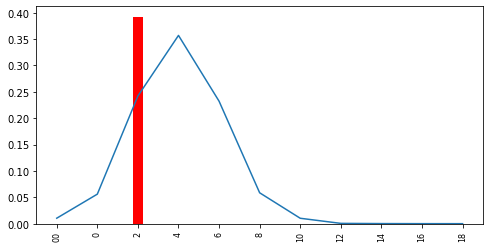

In [12]:
from random import randrange

ndx = randrange(len(X_test))
probs = model(X_test[ndx])
truth = torch.argmax(Y_test[ndx]).item()

plt.figure(figsize=(8, 4))
plt.plot(labels, probs.cpu().detach().numpy())
plt.bar(truth, 1.1*max(probs.cpu().detach().numpy()), width=.25, color='red')
plt.xticks(range(len(labels)), labels, fontsize=8, rotation='vertical');

### Additional training

Even though it is not obvious in the loss, we actually **do** get a narrower peak and often more accurate estimates with more epochs.

In [ ]:
do_training(model, X_train, target, optimizer, loss_fn, quiet=True, epochs=1000)

+++ Beginning 1000 epochs with batch size 1000
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Next Lesson

**Tasks with Networks**: This example was a relatively common one of making categorical predictions from independent features.  For this type of network generally uses primarily or exclusively linear layers.  Next we will take a look at an image classifer that will need some layers to associate nearby pixels.

<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="left"/></a>